In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import pickle
from itertools import product
import functools
import seaborn as sns
from plotnine import *
from plotnine.data import *
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

def plot_histogram(df, var, title): 
    plot = (ggplot(data = df, 
               mapping = aes(x = var)) +
             geom_histogram(colour = "black", fill = "white") +
     # 25% quantile
      geom_vline(aes(xintercept=df[var].quantile(.25)),
                color="blue", linetype="dashed", size=1) +
     # median
     geom_vline(aes(xintercept=df[var].quantile(.5)),
                color="blue", linetype="dashed", size=1)+
     # mean
     geom_vline(aes(xintercept=df[var].mean()),
                color="red", linetype="dashed", size=1)+
      # 75% quantile
      geom_vline(aes(xintercept=df[var].quantile(.75)),
                color="blue", linetype="dashed", size=1) +
     theme(element_text(angle = 90, vjust = 0.5, hjust=1)) +
     ggtitle(title)
    )
    
    print(plot)

# Volatility Cones

Volatility cones as first described in Burghart and Lane (1990) have two main benefits:

 - 1) *Placing implied volatility into context* : Trading volatility is inherently an uncertain enterprise since, unlike equities for example, there is no link to fundamental indicators like a firm's cash flows, earnings, etc. Instead, an asset's historical volatility is typically the best tool a quantitative trader might have to assess their IV forecast. Volatility cones provide a way for contextualizing volatility analysis, "The purpose of a volatility cone is to illustrate the ranges of volatility experience for different trading horizons." (p. 73 of Burghart and Lane (1990))
 
 
 - 2) *Signal generation/filtration*: By comparing an IV to the volatility's historical distribution, we are able to know if the volatility is above or beyond certain historical bounds. Burghart and Lane (1990) gives the example of Eurodollar options. They explain that those derivative contracts had an IV that was above the historic upper bound, as a result, we should have strong reason to believe that volatility would fall within the bounds. This is exactly what happened in the following weeks and being short the contracts was a profitable opportunity. Volatility cones therefore allow us to filter out any forecast we might have of IV or it can also act as a signal generator on its own since we can compare spot IV with the distribution outlined by the cone.
 
 Volatility cones can be calculated in several ways. This strategy employs the following method. We first begin by getting a few years worth of the underlying's fitted M-day historical volatilities from our predictive models.  We then can create non-overlapping windows of 10 trading days. For each window, we assign their decile (rank). We then calculate an exponentially weighted mean by rank -- putting more weight on more recent windows. Weights are created as follows:

$$
w_{i}= \begin{cases}\alpha(1-\alpha)^{i} & \text { if } i<t \\ (1-\alpha)^{i} & \text { if } i=t\end{cases}
$$

where $\alpha$ is the smoothing factor.

For each historical time period, we therefore have a volatility distribution -- in our case we have chosen the 1 to 10th decile.

# Trading Strategy

Once we have our volatility cones, our trading strategy becomes clear. On a daily basis, we examine the implied volatility of a particuliar option with M-days to expiry. We compare it to the historical realized volatility outlined by the volatility cone that we constructed. We then estimate an M-day realized volatility of the following day. We also compare this volatility forecast with the distribution outlined by the volatility cone. If the IV of the option is above/below a chosen boundary of the volatility cone and the next day realized volatility forecast is within the boundaries, we short/go long the option. 

Therefore our profit can be approximated by  
$$P/L = k*vega*(\sigma - \sigma_{implied}) \;\;\;\;\;\;\; (1)$$
where $vega$ is the how the option price changes with respect to the underlying's IV (formerly $\frac{\partial C}{\partial \sigma}$). $\sigma_{implied}$ is the volatility value required to be put in the well-known Black-Scholes options pricing equation in order to generate the observed price of the contract. Furthermore, if we hold the contracts till expiration and realized volatility amounts to $\sigma$ on average, we will  make $(1)$. This strategy will yield a positive PnL under two scenarios:

- 1) Total notional ($k * vega$) < 0 and $\sigma - \sigma_{implied} < 0$ (Shorted the option and volatility fell). 
- 2) Total notional ($k * vega$) < 0 and $\sigma - \sigma_{implied} > 0$ (Went long the option and volatility rose).

We consider this strategy for each of our thirteen microchip options and their respective underlyings (futures).






# Illustrative Example

For illustrative purposes, we show the construction of the volatility cones of the Invesco S&P 500 Eql Wght Energy ETF. We omit the step where we produce the fitted values from a predictive algorithm and instead simply use the one-day percent returns to generate the historical volatilities we input into the cone algorithm.

In [2]:
# Grab more data early to prevent NAs when calculating returns later
quandl.ApiConfig.api_key = 'jJeFoAcYubSY8xDcp3oy'
RYE = quandl.get_table('QUOTEMEDIA/PRICES', \
                       date = [d.strftime('%Y-%m-%d')\
                               for d in pd.date_range('20150101','20211130')], \
                       ticker='RYE')

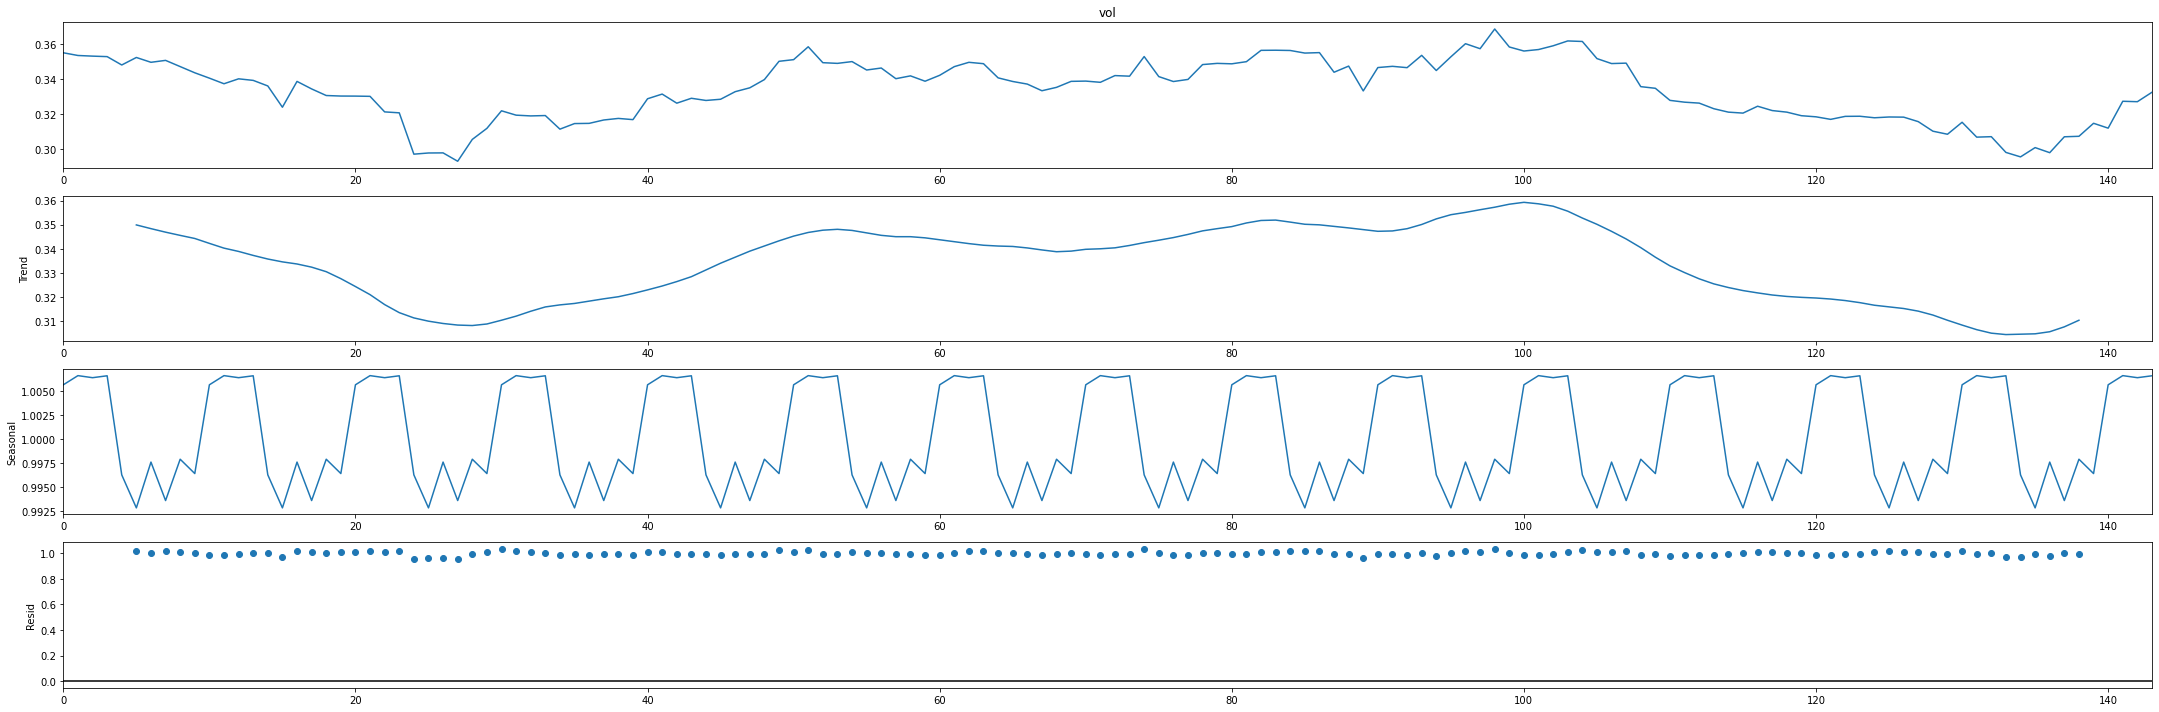

In [78]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
day_of_interest = "2021-11-23"
df = RYE.loc[:day_of_interest].copy()
df["return"] = df["adj_close"] / df["adj_close"].shift(1) - 1

df["vol"] = df["return"].rolling(i).std() * np.sqrt(252)
# df = df.reset_index()
df = df.dropna()
df = df.sort_values("date")
df = df.reset_index()
from statsmodels.tsa.seasonal import seasonal_decompose
series = df["vol"]
result = seasonal_decompose(series, model='multiplicative', period=10)
result.plot()
pyplot.show()

### Exponential weighting

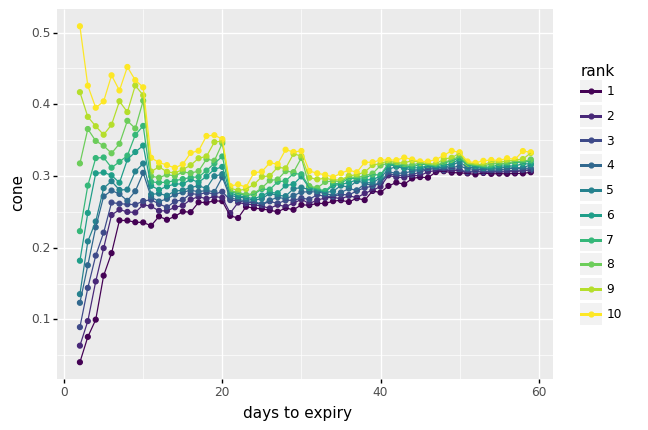

<ggplot: (337951946)>

In [62]:
w = "exp"
cones = []
for i in range(1, 60):
    day_of_interest = "2021-11-23"
    df = RYE.loc[:day_of_interest].copy()
    df["return"] = df["adj_close"] / df["adj_close"].shift(1) - 1
    df["vol"] = df["return"].rolling(i).std() * np.sqrt(252)
    df = df.reset_index()
    df = df.dropna()
    df = df.sort_values("date")
    df = df.groupby(df.index // 10).filter(lambda x: len(x) == 10).copy()
    df["rank"] = df.groupby(df.index // 10)["vol"].transform(pd.qcut,10, range(1, 11))
    # mean table / should try add exponential weighting 
    
    if w == "exp":
        df = pd.DataFrame({"cone" : df.sort_values(["rank", "date"], ascending = False).groupby("rank")["vol"].apply(lambda x: \
                                                       np.average(x, \
           weights = np.concatenate(([1-.05], [0.05 * (1-.05) ** j for j in range(1, len(x)) ]))))})
    elif w == "mean":
        df = pd.DataFrame({"cone" : df.groupby("rank")["vol"].mean()})
    df = df.reset_index(drop = False)
    df["days to expiry"] = i
    
    cones.append(df)

(ggplot(data = pd.concat(cones), mapping= aes(x = "days to expiry", y = "cone", color = "rank")) +
geom_point() +
geom_line())

### Equal weighting

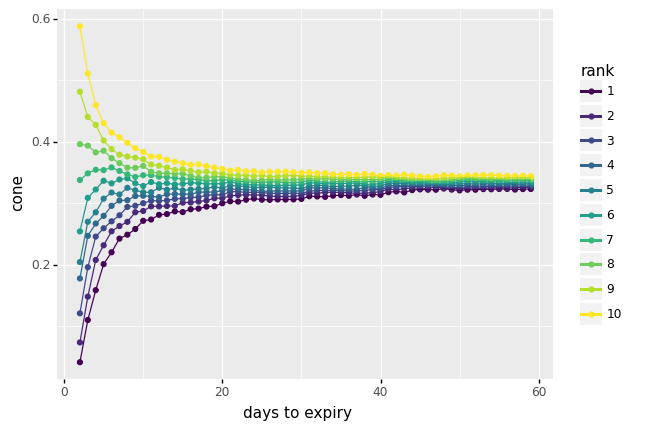

<ggplot: (336765537)>

In [61]:
w = "mean"
cones = []
for i in range(1, 60):
    day_of_interest = "2021-11-23"
    df = RYE.loc[:day_of_interest].copy()
    df["return"] = df["adj_close"] / df["adj_close"].shift(1) - 1
    df["vol"] = df["return"].rolling(i).std() * np.sqrt(252)
    df = df.reset_index()
    df = df.dropna()
    df = df.sort_values("date")
    df = df.groupby(df.index // 10).filter(lambda x: len(x) == 10).copy()
    df["rank"] = df.groupby(df.index // 10)["vol"].transform(pd.qcut,10, range(1, 11))
    # mean table / should try add exponential weighting 
    
    if w == "exp":
        df = pd.DataFrame({"cone" : df.sort_values(["rank", "date"], ascending = False).groupby("rank")["vol"].apply(lambda x: \
                                                       np.average(x, \
           weights = np.concatenate(([1-.05], [0.05 * (1-.05) ** i for i in range(1, len(x)) ]))))})
    elif w == "mean":
        df = pd.DataFrame({"cone" : df.groupby("rank")["vol"].mean()})
    df = df.reset_index(drop = False)
    df["days to expiry"] = i
    
    cones.append(df)

(ggplot(data = pd.concat(cones), mapping= aes(x = "days to expiry", y = "cone", color = "rank")) +
geom_point() +
geom_line())